# Data Loading and Previewing



In [1]:
import pandas as pd

rawData = pd.read_csv('https://raw.githubusercontent.com/skduong/anuran-calls/master/Frogs_MFCCs.csv')
rawData.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,0.188654,-0.075622,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,0.270958,-0.095004,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,0.266064,-0.072827,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,0.267279,-0.162258,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,0.332695,-0.100749,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [2]:
data = rawData[rawData.columns[:23]] #focus on Family classification
data['Family'].value_counts() #get class balance

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

Rebalancing is needed: undersample Leptodactylidae, oversamle Dendrobatidae with SMOTE, remove Bufondidae

In [3]:
import numpy as np
from imblearn.over_sampling import SMOTE

lepto = data.loc[data['Family'] == 'Leptodactylidae']
hyli = data.loc[data['Family'] == 'Hylidae']
dendro = data.loc[data['Family'] == 'Dendrobatidae']

#oversample dendro classes to match dendro
subset = pd.concat([hyli, dendro])
X = subset.drop(['Family'], 1)
y = subset['Family']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y) #X = data matrix, y = labels
oversample_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], 1)
oversample_df.columns = lepto.columns.values
#pd.Series(y).value_counts()

#randomly undersample lepto by 1420 cases
undersample = lepto.drop(np.random.choice(lepto.index, 1420, False))

#rebalanced data
data = pd.concat([undersample, oversample_df])
data['Family'].value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Leptodactylidae    3000
Hylidae            2165
Dendrobatidae      2165
Name: Family, dtype: int64

Improved balanced compared to before. Not perfect, but it's a compromise between losing too many Leptodactylidae cases and having heavy imbalance with the major class.

In [4]:
lepto = data.loc[data['Family'] == 'Leptodactylidae']
dendro = data.loc[data['Family'] == 'Dendrobatidae']
hyli = data.loc[data['Family'] == 'Hylidae']

data.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
count,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000
mean,0.991176,0.321484,0.259374,0.393081,0.149625,0.122551,0.017795,-0.012699,0.082450,0.055978,-0.068268,0.008243,0.084062,0.007508,-0.037293,0.005667,0.029965,0.012117,-0.022011,-0.039224,0.020874,0.058152
std,0.064673,0.207772,0.280419,0.172935,0.171889,0.117620,0.185305,0.119186,0.187501,0.141478,0.180635,0.163094,0.208240,0.162916,0.191568,0.125359,0.151173,0.080694,0.085427,0.088727,0.079161,0.116189
min,-0.251179,-0.673025,-0.436028,-0.472676,-0.539779,-0.410417,-0.538982,-0.576506,-0.513460,-0.952266,-0.901989,-0.799441,-0.644116,-0.590380,-0.578354,-0.498675,-0.405825,-0.759322,-0.680745,-0.361649,-0.430812,-0.375461
25%,1.000000,0.187352,0.048131,0.288047,0.057711,0.035968,-0.123716,-0.100636,-0.058288,-0.004150,-0.227955,-0.095464,-0.074477,-0.099077,-0.208032,-0.091756,-0.118077,-0.033379,-0.081374,-0.097086,-0.034177,-0.021175
50%,1.000000,0.305475,0.232017,0.392122,0.161370,0.113697,-0.018960,-0.007139,0.129541,0.064211,-0.065245,0.024706,0.073591,-0.015479,-0.047198,0.014423,0.035728,0.015242,-0.013462,-0.039042,0.010073,0.039897
75%,1.000000,0.432723,0.398094,0.530919,0.239373,0.199008,0.112621,0.064895,0.235680,0.134562,0.063253,0.096930,0.277804,0.129197,0.137786,0.078399,0.167300,0.062396,0.028452,0.013192,0.072203,0.163189
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,0.696887,0.551762,0.738033,0.522768,0.523033,0.639017,0.825393,0.566873,0.668924,0.670700,0.451186,0.614064,0.574209,0.467831,0.387363,0.432207


In [5]:
data.corr()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
MFCCs_ 1,1.000000,-0.255046,-0.320141,-0.008641,0.198469,-0.193573,-0.047732,0.033245,-0.032214,0.033234,0.007054,-0.071636,0.040164,0.057202,-0.053227,-0.031736,0.052229,-0.000518,-0.098551,-0.077550,0.043746,0.046918
MFCCs_ 2,-0.255046,1.000000,0.567575,-0.003101,-0.384287,0.023632,0.154448,0.233288,0.006642,-0.229292,0.029093,0.197963,-0.139203,-0.095922,0.209458,0.002536,-0.191481,0.039215,0.112446,0.085816,0.006043,-0.158585
MFCCs_ 3,-0.320141,0.567575,1.000000,0.264966,-0.719777,-0.000886,0.238665,0.105234,0.022334,-0.194377,0.049114,0.436558,0.002795,-0.366793,-0.043221,0.211047,0.101461,0.038308,-0.028490,0.167520,0.046186,-0.206368
MFCCs_ 4,-0.008641,-0.003101,0.264966,1.000000,0.063078,-0.655251,-0.454463,0.164206,0.513016,0.075253,-0.409039,0.314394,0.445143,-0.476459,-0.524739,0.384797,0.559689,0.048432,-0.376206,-0.362119,0.145398,0.389809
MFCCs_ 5,0.198469,-0.384287,-0.719777,0.063078,1.000000,-0.042355,-0.663831,-0.273840,0.301016,0.384987,-0.101455,-0.331138,-0.004095,0.122606,0.012284,0.042512,-0.032729,-0.128517,0.104669,-0.109625,-0.209720,0.124877
MFCCs_ 6,-0.193573,0.023632,-0.000886,-0.655251,-0.042355,1.000000,0.347646,-0.457347,-0.320420,0.066750,0.276154,-0.160853,-0.301210,0.245242,0.379381,-0.157172,-0.421874,-0.174827,0.345039,0.432266,-0.115226,-0.394758
MFCCs_ 7,-0.047732,0.154448,0.238665,-0.454463,-0.663831,0.347646,1.000000,0.149487,-0.794942,-0.287241,0.481635,-0.094908,-0.305586,0.370430,0.279657,-0.456255,-0.306173,0.154236,0.081223,0.235973,0.137536,-0.273383
MFCCs_ 8,0.033245,0.233288,0.105234,0.164206,-0.273840,-0.457347,0.149487,1.000000,0.162629,-0.719411,-0.307213,0.429736,0.224598,-0.185852,-0.116965,0.050988,0.124055,0.101014,-0.289969,-0.259364,0.307202,0.280090
MFCCs_ 9,-0.032214,0.006642,0.022334,0.513016,0.301016,-0.320420,-0.794942,0.162629,1.000000,0.078185,-0.803971,0.310658,0.598241,-0.498474,-0.452149,0.591100,0.464006,-0.204577,-0.231608,-0.279895,0.005105,0.401273
MFCCs_10,0.033234,-0.229292,-0.194377,0.075253,0.384987,0.066750,-0.287241,-0.719411,0.078185,1.000000,0.146136,-0.681454,-0.076561,0.338251,-0.002689,-0.073079,0.019677,-0.061096,0.159909,0.060514,-0.302742,-0.071240


#Evaluating Feature Discriminating Power 

To see if any of the MFCCs have more influence on class decision, the discriminating power for each feature, F, between disjoint classes CLi and CLj (with combined size N) will be calculated using:

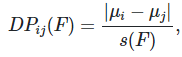   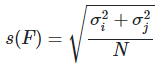



In [6]:
def DP(i, j): #take 2 classes, give discriminating power between them for all 22 features
  i = i.drop(['Family'],1); j = j.drop(['Family'],1)
  N = len(i)+len(j)
  sF = ((i.var()+j.var())/N)**0.5
  DP = abs(i.mean()-j.mean())/sF
  return DP.sort_values(0,False)

ld = DP(lepto, dendro)
dh = DP(dendro, hyli)
lh = DP(lepto, hyli)

print('Top 3 descriminating features for each pair of classes: \n', 'Lepto & Dendro:\n', ld.iloc[0:3], '\n\nDendro & Hyli:\n',dh.iloc[0:3], '\n\nLepto & Hyli:\n', lh.iloc[0:3], sep='')

Top 3 descriminating features for each pair of classes: 
Lepto & Dendro:
MFCCs_17    156.642078
MFCCs_15    117.321550
MFCCs_19    113.492035
dtype: float64

Dendro & Hyli:
MFCCs_ 3    90.682019
MFCCs_14    77.361347
MFCCs_16    73.054011
dtype: float64

Lepto & Hyli:
MFCCs_19    89.183670
MFCCs_22    86.072518
MFCCs_17    71.696875
dtype: float64


It appears that MFCCs 17 and 19 are the most influential in distinguishing Leptodactylidae frogs from the other 2. 

(array([1.000e+00, 5.000e+00, 5.800e+01, 6.440e+02, 1.287e+03, 1.420e+02,
        2.400e+01, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([-0.38965599, -0.2932695 , -0.196883  , -0.1004965 , -0.00411001,
         0.09227649,  0.18866299,  0.28504948,  0.38143598,  0.47782248,
         0.57420897]),
 <a list of 10 Patch objects>)

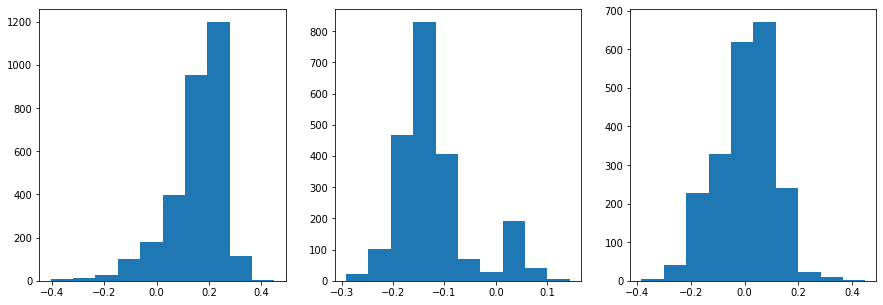

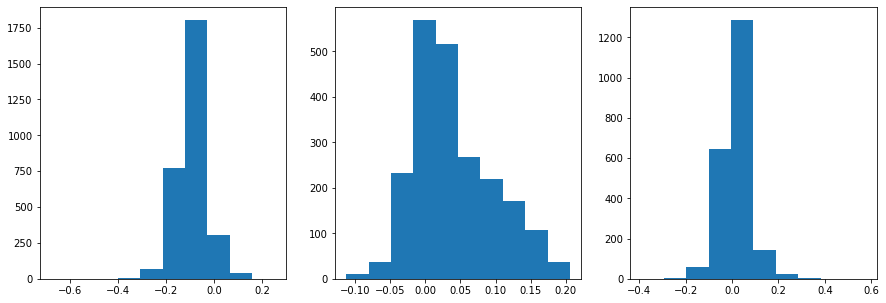

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].hist(lepto['MFCCs_17'])
axes[1].hist(dendro['MFCCs_17'])
axes[2].hist(hyli['MFCCs_17'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].hist(lepto['MFCCs_19'])
axes[1].hist(dendro['MFCCs_19'])
axes[2].hist(hyli['MFCCs_19'])

We can visually see why MFCCs 17 (top) & 19 (bottom) have such a high discriminating power. For each class, these values take on a distinct range (eg. MFCC17 is mostly positive for Leptodactylidae, negative for Dendrobatidae, and very close to zero for Hylidae). 

#KNN
(reference: https://realpython.com/knn-python/ )

Split Data into Train/Test Sets

In [31]:
from sklearn.model_selection import train_test_split

X = np.array(data.drop(['Family'], 1))
#encode family names to integer type
#encode = {'Leptodactylidae':0, 'Dendrobatidae':1, 'Hylidae':2}
#y = np.array(list(map(encode.get, data['Family'])), dtype=float)
y = data['Family']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("training set = %d cases\ntest set = %d cases\n" %(len(X_train), len(X_test)))

training set = 5864 cases
test set = 1466 cases



Training KNN model

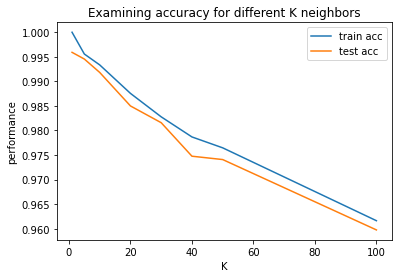

In [32]:
from sklearn.neighbors import KNeighborsClassifier

#evaluating performance of different sized K neighbors; start with a broad range to get a general idea
K_test = [1,5,10,20,30,40,50,100]
K_acc_train = []; K_acc_test = []

for k in K_test:
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(X_train, y_train)
  K_acc_train.append(sum(knn_model.predict(X_train) == y_train)/len(y_train))
  K_acc_test.append(sum(knn_model.predict(X_test) == y_test)/len(y_test))

plt.plot(K_test, K_acc_train, label = "train acc") 
plt.plot(K_test, K_acc_test, label = "test acc")
# set axis labels
plt.xlabel('K')
plt.ylabel('performance')
# Set a title of the current axes.
plt.title('Examining accuracy for different K neighbors')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

A closer look at K from 1 to 10

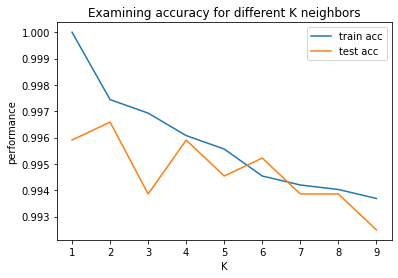

In [34]:
K_test = range(1,10)
K_acc_train = []; K_acc_test = []

for k in K_test:
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(X_train, y_train)
  K_acc_train.append(sum(knn_model.predict(X_train) == y_train)/len(y_train))
  K_acc_test.append(sum(knn_model.predict(X_test) == y_test)/len(y_test))

plt.plot(K_test, K_acc_train, label = "train acc") 
plt.plot(K_test, K_acc_test, label = "test acc")
# set axis labels
plt.xlabel('K')
plt.ylabel('performance')
# Set a title of the current axes.
plt.title('Examining accuracy for different K neighbors')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

Performance is highest at lower K values, but we also want the lowest possible overfit, which occurs when K=4. Proceed with K_best = 4.

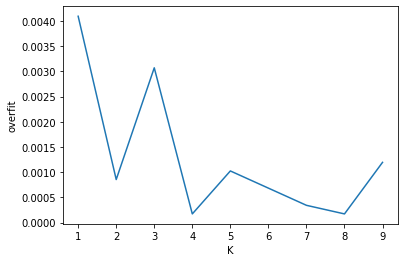

In [36]:
overfit = abs(np.array(K_acc_train) - np.array(K_acc_test))
plt.plot(K_test, overfit) 
plt.xlabel('K'); plt.ylabel('overfit')
plt.show()

Confusion Matrices for evaluating accuracy by classes

In [37]:
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train, y_train)

def conf(actu, pred): #returns confusion matrix in percentages + global accuracies
  y_actu = pd.Series(np.array(actu), name = 'Actual')
  y_pred = pd.Series(pred, name = 'Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion.divide(df_confusion.sum(axis=1),axis=0), sum(np.diag(df_confusion))/sum(np.sum(df_confusion))

trainConf, trainGlobal = conf(y_train, knn_model.predict(X_train))
print('Train:\n', trainConf,'\nGlobal: ', trainGlobal)

testConf, testGlobal = conf(y_test, knn_model.predict(X_test))
print('\nTest:\n', testConf, '\nGlobal: ', testGlobal)

Train:
 Predicted        Dendrobatidae   Hylidae  Leptodactylidae
Actual                                                   
Dendrobatidae         1.000000  0.000000         0.000000
Hylidae               0.003409  0.993182         0.003409
Leptodactylidae       0.000000  0.004538         0.995462 
Global:  0.9960777626193724

Test:
 Predicted        Dendrobatidae   Hylidae  Leptodactylidae
Actual                                                   
Dendrobatidae         1.000000  0.000000         0.000000
Hylidae               0.002469  0.987654         0.009877
Leptodactylidae       0.000000  0.001736         0.998264 
Global:  0.9959072305593452


Very good performance. Hylidae cases are the most misidentified

Confidence Intervals

#PCA